# Multiclass SVM implementations from scratch using sub-gradient descent

This is a pure numpy implementation to understand the inner workings of SVMs.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from random import randrange

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We use mnist as our dataset. Bare in mind, that we are also dealing with a multi-class classification problem. So we have to consider this as a one vs all classifier.

Let's use tensorflow to download our dataset.

https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html
https://cs231n.github.io/linear-classify/#svm

## Read in data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
n_samples, _, _ = X_train.shape

In [6]:
# We will also make a development set, which is a small subset of
# the training set.
n_dev = 500
mask = np.random.choice(n_samples, n_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

Some helper functions for preprocessing

In [7]:
def one_hot(labels):
    unique_labels = np.unique(labels)
    return (unique_labels == labels[:, np.newaxis]).astype(int)

def preprocess(X_train, y_train, X_test, y_test):
    fac = 255 * 0.99 + 0.01
    X_train = X_train / fac
    X_test = X_test / fac
    X_train = X_train.astype(np.float32) 
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32) 
    y_test = y_test.astype(np.float32)
#     y_train = one_hot(y_train)
#     y_test = one_hot(y_test)
    return X_train, y_train, X_test, y_test

def flatten2d(X):
    return X.reshape(X.shape[0], -1)

## Visualize images

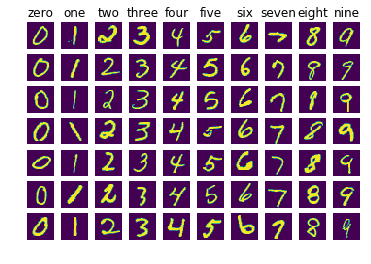

In [8]:
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
n_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Preprocess data

In [9]:
X_train = flatten2d(X_train)
X_test = flatten2d(X_test)
X_dev = flatten2d(X_dev)
# Preprocessing
# X_train, y_train, X_test, y_test = preprocess(X_train, y_train, X_test, y_test)
# mean_image = np.mean(X_train, axis=0)
# X_train = X_train - mean_image
# X_test = X_test - mean_image
# X_dev = X_dev - mean_image
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_dev = y_dev.astype(np.int32)
# y_train = y_train[..., None]
# y_test = y_test[..., None]
print(f"X_train.shape={X_train.shape}")
print(f"X_test.shape={X_test.shape}")
print(f"X_dev.shape={X_dev.shape}")
print(f"y_train.shape={y_train.shape}")
print(f"y_test.shape={y_test.shape}")
print(f"y_dev.shape={y_dev.shape}")

X_train.shape=(60000, 784)
X_test.shape=(10000, 784)
X_dev.shape=(500, 784)
y_train.shape=(60000,)
y_test.shape=(10000,)
y_dev.shape=(500,)


In [10]:
n_samples, n_features = X_train.shape
# n_classes = y_train.shape[1]
n_classes = np.max(y_train) + 1
n_dev = 500
print(f"n_samples={n_samples}, n_features={n_features}")
print(f"n_classes={n_classes}")

n_samples=60000, n_features=784
n_classes=10


Can also substract mean from train and test image

In [11]:
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_test -= mean_image

In [12]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

## Vectorized implementation

In [28]:
class SVM():
    
    def __init__(self, delta=1., reg=0.01):
        self.delta = delta
        self.reg = reg
        
    def loss_single(self, y, y_pred):
        n_samples = y.shape[0]
        correct_class_preds = y_pred[np.arange(n_samples), y][:, np.newaxis]
        margin = np.maximum(0, y_pred - correct_class_preds + self.delta)
        margin[np.arange(n_samples), y] = 0
        return margin
       
    def loss(self, y, y_pred, w, train=True):
        """Return loss
        """
        n_samples = y.shape[0]
        margin = self.loss_single(y, y_pred)
        loss = margin.sum() / n_samples
        # Add regularization
        loss = loss + self.reg * np.sum(w * w)
        if train:
            self.margin = margin
        return loss
        
    def forward(self, X, w):
        """Perform forward pass
        """
        return np.dot(X, w)
    
    def accuracy(self, y, y_pred):
        if y_pred.ndim > 1:
            y_pred_flatten = np.argmax(y_pred, axis=1)
        else:
            y_pred_flatten = y_pred.copy()
            
        return (y == y_pred_flatten).sum() / y.shape[0]
    
    def backward(self, X, y, w):
        """Perform backprop
        """
        # We create a mask since the gradient of cost-sensitive multiclass loss is -x
        # for correct class and x for other classes
        n_samples = self.margin.shape[0]
        X_mask = np.zeros(self.margin.shape)
        X_mask[self.margin > 0] = 1 # We utilize classes that have greater than 0 margin
        valid_margin_count = X_mask.sum(axis=1) # Count how many classes have margin > 0
        X_mask[np.arange(n_samples), y] = -valid_margin_count
        dW = (np.dot(X.T, X_mask) / n_samples)
        dW = dW + 2 * self.reg * w
        return dW

## Analytical gradient check

In [32]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [33]:
w = np.random.randn(n_features + 1, n_classes)
svm = SVM()

In [34]:
pred = svm.forward(X_dev, w)
loss = svm.loss(y_dev, pred, w)
grad = svm.backward(X_dev, y_dev, w)
def f(w):
    p = svm.forward(X_dev, w)
    loss = svm.loss(y_dev, p, w, train=False)
    return loss
    
# f = lambda w: svm.loss(X_dev, y_dev, w, reg=5e1)[0]
grad_numerical = grad_check_sparse(f, w, grad)

numerical: 0.007823 analytic: 0.007823, relative error: 3.316520e-06
numerical: 0.348043 analytic: 0.348043, relative error: 1.094098e-09
numerical: 8.413546 analytic: 8.413546, relative error: 1.052773e-09
numerical: -0.020087 analytic: -0.020087, relative error: 1.724346e-07
numerical: 66.495054 analytic: 66.495054, relative error: 2.171249e-11
numerical: 39.600449 analytic: 39.600450, relative error: 1.215277e-09
numerical: 5.957031 analytic: 5.957031, relative error: 3.045392e-09
numerical: -59.539141 analytic: -59.539141, relative error: 4.150794e-10
numerical: 0.280947 analytic: 0.280947, relative error: 8.827120e-08
numerical: 0.427597 analytic: 0.427597, relative error: 4.195851e-08


## Train

In [181]:
w = np.random.randn(n_features + 1, n_classes) * 0.001
batch_size = 64
alpha = 1e-6
delta = 1.
reg = 1e3

svm = SVM(delta=delta, reg=reg)

In [182]:
# Iterate through number of samples
epochs = 4000
train_loss_history = []
test_loss_history = []
sv = np.zeros((n_samples,))
for epoch in range(epochs):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    # predict
    y_pred = svm.forward(X_batch, w)
    l = svm.loss_single(y_batch, y_pred)
    # Keep track of support vectors ?
    sv[batch_idxs[np.unique(np.argwhere(l > 0)[:, 0])]] += 1
    # Calculate loss
    train_loss = svm.loss(y_batch, y_pred, w)
    test_loss = svm.loss(y_test, svm.forward(X_test, w), w, train=False)
    # Calculate gradients
    dW = svm.backward(X_batch, y_batch, w)
    # Update parameters
    w = w - alpha * dW
    # Track loss
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch={epoch}/{epochs}: loss={train_loss:.4f}, test_loss={test_loss:.4f}")

Epoch=0/4000: loss=24.8857, test_loss=24.6633
Epoch=100/4000: loss=6.6072, test_loss=6.1257
Epoch=200/4000: loss=3.9298, test_loss=4.1843
Epoch=300/4000: loss=3.1500, test_loss=2.9663
Epoch=400/4000: loss=2.3166, test_loss=2.1968
Epoch=500/4000: loss=1.7070, test_loss=1.7076
Epoch=600/4000: loss=1.4852, test_loss=1.3472
Epoch=700/4000: loss=1.2137, test_loss=1.1564
Epoch=800/4000: loss=0.8580, test_loss=1.0204
Epoch=900/4000: loss=1.0252, test_loss=0.8881
Epoch=1000/4000: loss=0.8277, test_loss=0.8782
Epoch=1100/4000: loss=0.9957, test_loss=0.8378
Epoch=1200/4000: loss=0.8436, test_loss=0.7799
Epoch=1300/4000: loss=0.7056, test_loss=0.7649
Epoch=1400/4000: loss=0.7116, test_loss=0.7389
Epoch=1500/4000: loss=0.6488, test_loss=0.7506
Epoch=1600/4000: loss=0.7582, test_loss=0.7759
Epoch=1700/4000: loss=0.5590, test_loss=0.7289
Epoch=1800/4000: loss=1.1602, test_loss=0.7525
Epoch=1900/4000: loss=0.5983, test_loss=0.7213
Epoch=2000/4000: loss=0.6504, test_loss=0.7575
Epoch=2100/4000: loss=0

In [183]:
preds = svm.forward(X_train, w)

In [184]:
sv.nonzero()[0].shape

(31836,)

In [185]:
np.unique(l.nonzero()[0])

array([ 1,  4,  5,  6,  8, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23,
       25, 26, 28, 34, 35, 36, 38, 39, 41, 47, 49, 54, 56, 60, 61, 62])

In [186]:
losses = svm.loss_single(y_train, preds)

In [187]:
supports = np.unique(np.argwhere(losses > 0)[:, 0])

In [188]:
supports.shape

(22313,)

## Evaluation

### Loss evaluation

Train loss

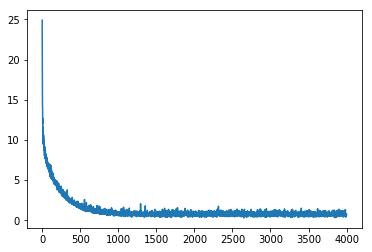

In [189]:
plt.plot(train_loss_history)

Test loss

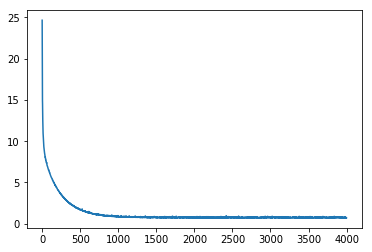

In [190]:
plt.plot(test_loss_history)

### Accuracy

In [191]:
y_train_preds = svm.forward(X_train, w)
y_test_preds = svm.forward(X_test, w)

In [192]:
train_acc = svm.accuracy(y_train, y_train_preds)
test_acc = svm.accuracy(y_test, y_test_preds)
print(f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

train_acc=0.8930, test_acc=0.9011
